# Object Detection with YOLO in Keras

In this exercise, you'll use a Keras implementation of YOLO to detect objects in an image.

## Install Keras
First, let's ensure that the latest version of Keras is installed.

In [1]:
!pip install --upgrade keras

Requirement already up-to-date: keras in /home/nbuser/anaconda3_501/lib/python3.6/site-packages (2.2.4)


## Download and Convert YOLO weights
YOLO is based on the Darknet model architecture - an open-source model written in C. The creators of this model have provided pre-trained weights that were trained on the [Common Objects in Context (COCO) dataset](cocodataset.org) - a common set of sample images for computer vision research.

Run the following cell to download the weights, and convert them into a suitable format for use with Keras.

> _**Note**: This can take some time to run_

In [ ]:
!wget https://pjreddie.com/media/files/yolov3.weights -O yolo_keras/yolo3.weights
!python yolo_keras/convert.py yolo_keras/yolov3.cfg yolo_keras/yolo3.weights yolo_keras/yolo.h5

After the weights have been downloaded, the layers in the model are described.

## Load the Weights into a Keras Model

Now that we have the weights, we can load them into a Keras model.

> **Note** The code to implement the Keras model is in **yolo_keras/model.py**. Additionally, **yolo_keras/utils.py** contains some functions that are used to assemble and use the model.

In [2]:
import os
import numpy as np

from keras import backend as K
from keras.models import load_model
from keras.layers import Input

from yolo_keras.utils import *
from yolo_keras.model import *

# Get the COCO classes on which the model was trained
classes_path = "yolo_keras/coco_classes.txt"
with open(classes_path) as f:
    class_names = f.readlines()
    class_names = [c.strip() for c in class_names] 
num_classes = len(class_names)

# Get the anchor box coordinates for the model
anchors_path = "yolo_keras/yolo_anchors.txt"
with open(anchors_path) as f:
    anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    anchors = np.array(anchors).reshape(-1, 2)
num_anchors = len(anchors)

# Set the expected image size for the model
model_image_size = (416, 416)

# Create YOLO model
model_path = "yolo_keras/yolo.h5"
yolo_model = load_model(model_path, compile=False)

# Generate output tensor targets for bounding box predictions
# Predictions for individual objects are based on a detection probability threshold of 0.3
# and an IoU threshold for non-max suppression of 0.45
input_image_shape = K.placeholder(shape=(2, ))
boxes, scores, classes = yolo_eval(yolo_model.output, anchors, len(class_names), input_image_shape,
                                    score_threshold=0.3, iou_threshold=0.45)

print("YOLO model ready!")

Using TensorFlow backend.


YOLO model ready!


## Use the Model to Detect Objects

Now we're ready to use the YOLO model to detect objects in images.

### Create functions to detect and display objects
We'll create a couple of functions:

- **detect_objects**: Submits an image to the model and returns predicted object locations
- **show_objects**: Displays the image with a bounding box fo each detected object.

In [23]:
def detect_objects(image):
    
    # normalize and reshape image data
    image_data = np.array(image, dtype='float32')
    image_data /= 255.
    image_data = np.expand_dims(image_data, 0)  # Add batch dimension.

    # Predict classes and locations using Tensorflow session
    sess = K.get_session()
    out_boxes, out_scores, out_classes = sess.run(
                [boxes, scores, classes],
                feed_dict={
                    yolo_model.input: image_data,
                    input_image_shape: [image.size[1], image.size[0]],
                    K.learning_phase(): 0
                })
    return out_boxes, out_scores, out_classes

def show_objects(image, out_boxes, out_scores, out_classes):
    import random
    from PIL import Image
    import matplotlib.patches as patches
    import matplotlib.pyplot as plt

    %matplotlib inline 
    
    # Set up some display formatting
    cmap = plt.get_cmap('tab20b')
    colors = [cmap(i) for i in np.linspace(0, 1, 20)]

    # Plot the image
    img = np.array(image)
    plt.figure()
    fig, ax = plt.subplots(1, figsize=(12,9))
    ax.imshow(img)

    # Set up padding for boxes
    img_size = model_image_size[0]
    pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
    pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
    unpad_h = img_size - pad_y
    unpad_w = img_size - pad_x

    # Use a random color for each class
    unique_labels = np.unique(out_classes)
    n_cls_preds = len(unique_labels)
    bbox_colors = random.sample(colors, n_cls_preds)

    # process each instance of each class that was found
    for i, c in reversed(list(enumerate(out_classes))):

        # Get the class name
        predicted_class = class_names[c]
        # Get the box coordinate and probability score for this instance
        box = out_boxes[i]
        score = out_scores[i]

        # Format the label to be added to the image for this instance
        label = '{} {:.2f}'.format(predicted_class, score)

        # Get the box coordinates
        top, left, bottom, right = box
        y1 = max(0, np.floor(top + 0.5).astype('int32'))
        x1 = max(0, np.floor(left + 0.5).astype('int32'))
        y2 = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
        x2 = min(image.size[0], np.floor(right + 0.5).astype('int32'))

        # Set the box dimensions
        box_h = ((y2 - y1) / unpad_h) * img.shape[0]
        box_w = ((x2 - x1) / unpad_w) * img.shape[1]
        y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
        x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
        
        # Add a box with the color for this class
        color = bbox_colors[int(np.where(unique_labels == c)[0])]
        bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(bbox)
        plt.text(x1, y1, s=label, color='white', verticalalignment='top',
                bbox={'color': color, 'pad': 0})
        
    plt.axis('off')
    plt.show()
    
print("Functions ready")

### Use the functions with test images
Now we're ready to get some predictions from our test images.

Found 6 objects in 007152.jpg


<Figure size 432x288 with 0 Axes>

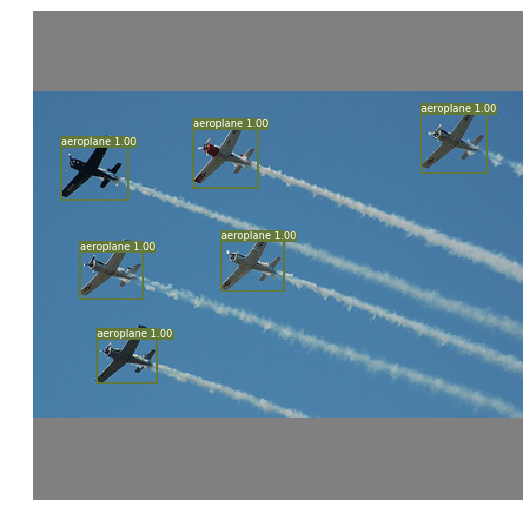

Found 2 objects in 007280.jpg


<Figure size 432x288 with 0 Axes>

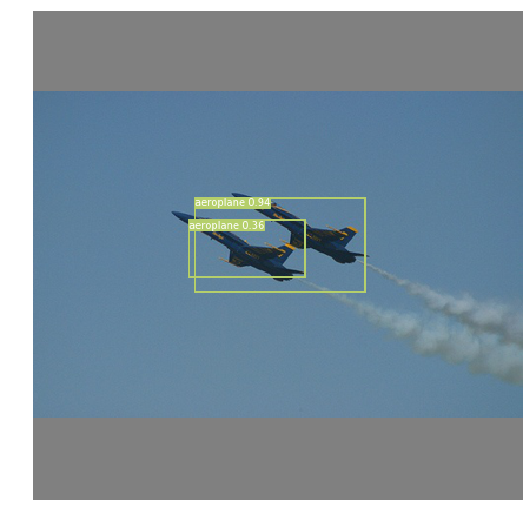

Found 2 objects in 000060.jpg


<Figure size 432x288 with 0 Axes>

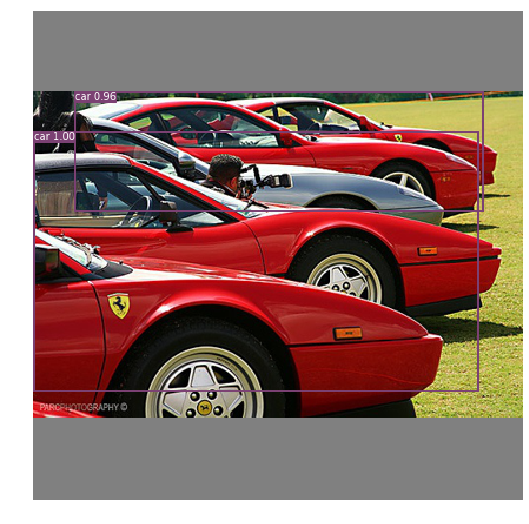

Found 3 objects in 006375.jpg


<Figure size 432x288 with 0 Axes>

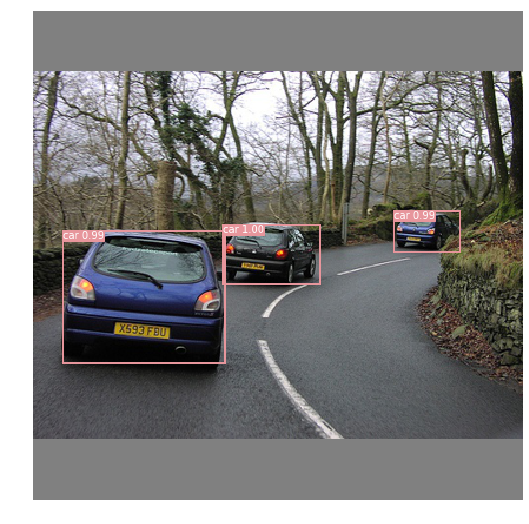

In [27]:
import os
from PIL import Image

test_dir = "test"
for image_file in os.listdir(test_dir):
    
    # Load image
    img_path = os.path.join(test_dir, image_file)
    image = Image.open(img_path)
    
    # Resize image for model input
    image = letterbox_image(image, tuple(reversed(model_image_size)))

    # Detect objects in the image
    out_boxes, out_scores, out_classes = detect_objects(image)

    # How many objects did we detect?
    print('Found {} objects in {}'.format(len(out_boxes), image_file))

    # Display the image with bounding boxes
    show_objects(image, out_boxes, out_scores, out_classes)

## Acknowledgements and Citations
The original YOLO documentation is at https://pjreddie.com/darknet/yolo/.

The Keras implementation of YOLO used in this exercise is based on the work of qqwweee at https://github.com/qqwweee/keras-yolo3, with some simplifications.

The test images used in this exercise are from the PASCAL Visual Object Classes Challenge (VOC2007) dataset at http://host.robots.ox.ac.uk/pascal/VOC/voc2007/.


    @misc{pascal-voc-2007,
        author = "Everingham, M. and Van~Gool, L. and Williams, C. K. I. and Winn, J. and Zisserman, A.",
        title = "The {PASCAL} {V}isual {O}bject {C}lasses {C}hallenge 2007 {(VOC2007)} {R}esults",
        howpublished = "http://www.pascal-network.org/challenges/VOC/voc2007/workshop/index.html"}
